<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Андрей Сухарев (@fremis)

## <center> Индивидуальный проект по анализу данных </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

In [118]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import glob
import random

np.random.seed(42)

###  1. Описание набора данных и признаков

Почти каждый день появляются новости, в которых разные виды нейронных сетей ставят очередную планку качества в решении той или иной задачи. В частности, в последние годы большой прирост качества мы можем наблюдать в решении задачи классификации изображений при помощи искусственных нейронных сетей, а именно свёрточных нейронных сетей (CNN).

Может сложиться впечатление, что нейронные сети могут решить абсолютно любую задачу (и ведь это отчасти так: нейронная сеть является универсальным аппроксиматором при достаточном количестве слоёв), и другие модели машинного обучения вроде логистической регрессии и градиентного бустинга на решающих деревьях больше не нужны.

Однако, если вы посмотрите, что общего между задачами, решаемыми при помощи нейронных сетей, то заметите, что входными данными для них выступают:
* Изображения (классификация, стилизация и т.п.)
* Звуковые сигналы (распознавание речи и т.п.)
* Текст (обработка естесственного языка)

Все эти типы данных объединяет одно: <i>локальные свойства</i>. Если в типичной задаче, решаемой xgboost'ом, вам на вход подаётся таблица признаков, порядок которых абсолютно неважен (какая разница, выставите вы сначала "пол", потом "возраст" или наоборот), то в изображениях группы соседних пикселей описывают какой-нибудь признак (например, нос котика). То же самое касается звуковых сигналов: последовательность частот в соседних звуковых интервалах может иметь свой смысл, который можно использовать для решения задачи.

В данном проекте будет рассмотрена задача классификации звуковых сигналов при помощи свёрточной нейронной сети.

Данная задача имеет множество применений, как то:
* Идентификация говорящего
* Определение интонации и настроения говорящего (воскрицательная, вопросительная интонации, гнев, радость и т.д.)
* Определение животного перед микрофоном в лесу
* и др.

Но больше интересно не её самостоятельное применение, а в совокупности с другими.

Решаться задача будет на общедоступном наборе данных <a href="https://github.com/karoldvl/ESC-50">ESC-50</a>, созданном польским исследователем Karol J. Piczak на основе звуков с Freesound. 

Соответственно, на входе мы имеем звуковой сигнал с заданной частотой дискретизации. Необходимо определить, к какому классу он относится.

Всю необходимую информацию о файле можно найти в его названии и пути:
```
category_id - category_name/fold_number-Freesound_clip_ID-take_letter.ogg
```

###  2. Первичный анализ данных

В данном наборе находится 2000 звуковых файлов, размеченных по 50 классам: лай собаки, плач ребёнка, стук в дверь и т.д. Полное описание всех классов можно найти на странице с набором данных. Набор уже разделён на 5 фолдов. Набор является сбалансированным, т.е. на каждый класс в каждом фолде приходится одинаковое число записей.

Частота дискретизации файлов: 44 кГц, содержатся они в контейнере ogg.

Посмотрим на примеры данных.

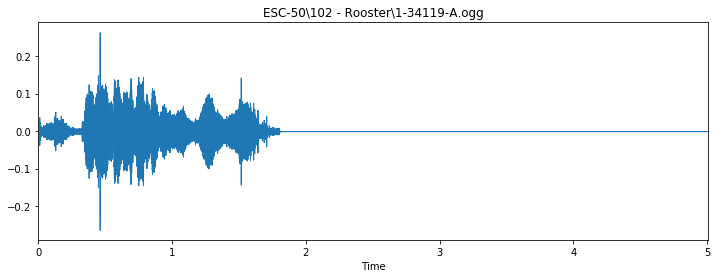

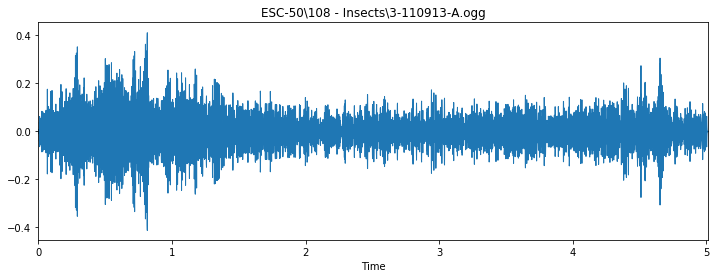

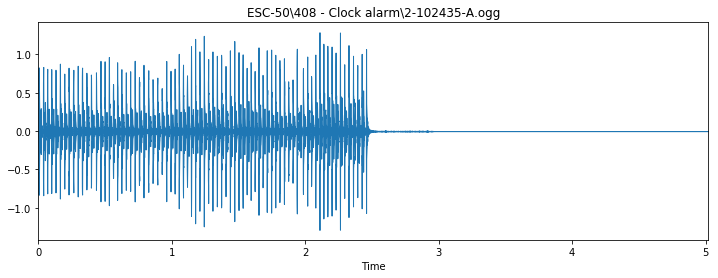

In [134]:
all_recordings = glob.glob('ESC-50/*/*.ogg')

def plot_wave(audio_name):
    x, sr = librosa.load(audio_name)

    plt.figure(figsize=(12, 4))
    plt.title(audio_name)
    librosa.display.waveplot(x, sr=sr);

plot_wave(all_recordings[42])
plot_wave(all_recordings[300])
plot_wave(all_recordings[1488])

Можно увидеть, что звуковые сигналы не всегда имеют настоящую продолжительность в 5 секунд. При разрезании на кусочки данный момент будет учитываться, что описано в разделе с предобработкой.

Также можно увидеть, что амплитуда колебаний по модулю не превосходит 1, значит дополнительная нормализация не требуется.

### 3 и 4. Первичный визуальный анализ данных. Инсайты, найденные зависимости

Визуализируем логарифмированные мел-спектрограмммы звуковых сигналов, которые будут служить основой для нашей модели

In [127]:
bands = 60

FFT_WINDOW = 1024
HOP = 512

def plot_spec(file_name):
    X, sr = librosa.load(file_name)

    S = librosa.feature.melspectrogram(X,
                                       n_fft=FFT_WINDOW, hop_length=HOP,
                                       sr=22050, n_mels=bands)
    logS = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(15, 7))
    plt.title(file_name)
    librosa.display.specshow(logS,
                             y_axis='mel',
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

Посмотрим на примеры лая собак.

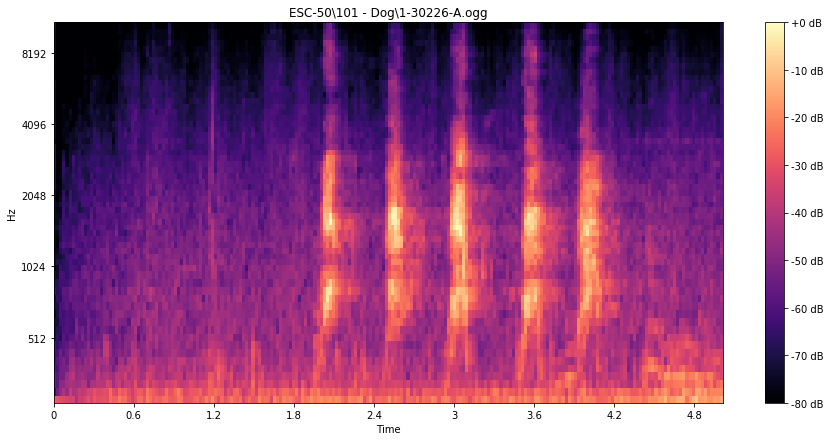

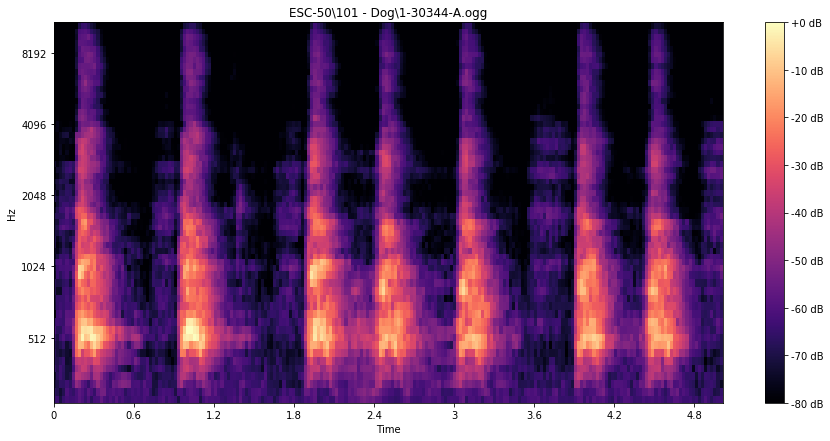

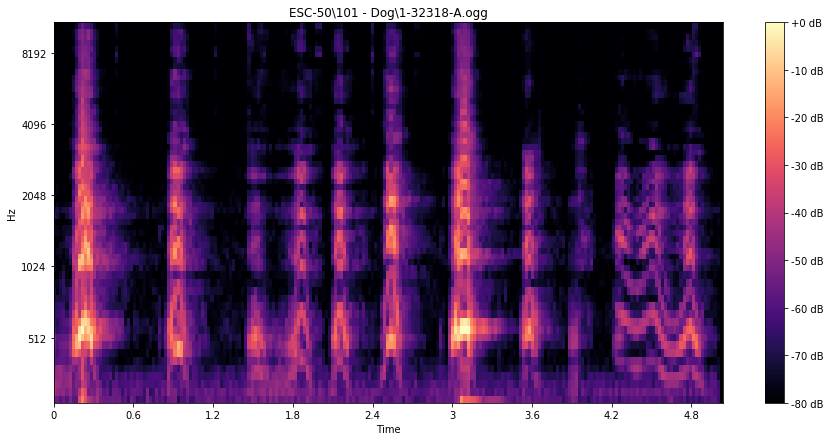

In [128]:
dog1_name = os.path.join('ESC-50', '101 - Dog', '1-30226-A.ogg')
dog2_name = os.path.join('ESC-50', '101 - Dog', '1-30344-A.ogg')
dog3_name = os.path.join('ESC-50', '101 - Dog', '1-32318-A.ogg')

plot_spec(dog1_name)
plot_spec(dog2_name)
plot_spec(dog3_name)

Можно увидеть, что лай собак имеет чёткие всплески короткой продолжительности практически во всём спектре. Раз это можно заметить глазом, значит и сетка это вполне способна увидеть.

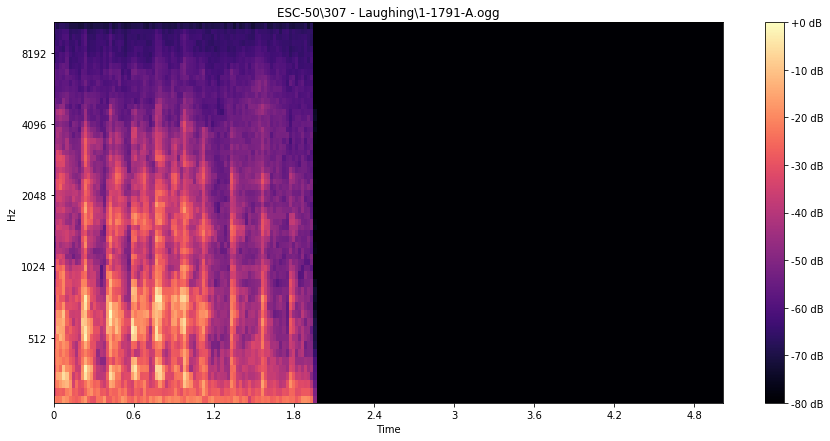

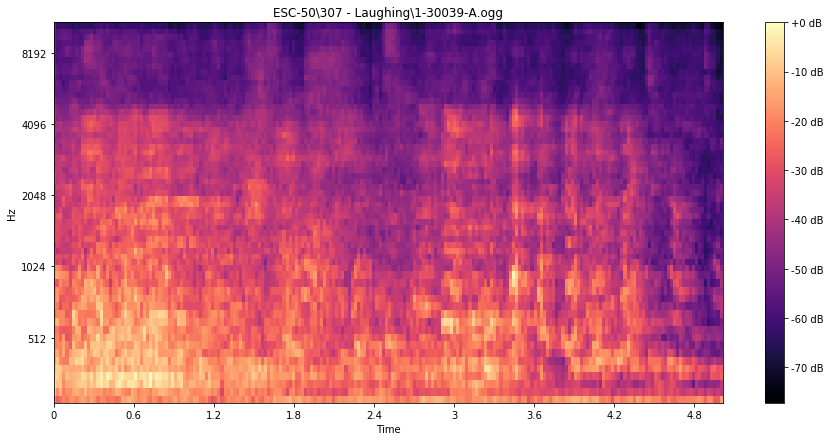

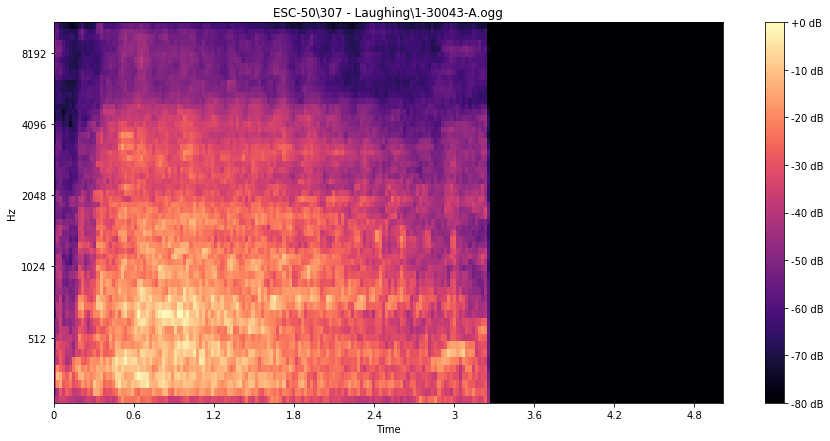

In [129]:
laugh1_name = os.path.join('ESC-50', '307 - Laughing', '1-1791-A.ogg')
laugh2_name = os.path.join('ESC-50', '307 - Laughing', '1-30039-A.ogg')
laugh3_name = os.path.join('ESC-50', '307 - Laughing', '1-30043-A.ogg')

plot_spec(laugh1_name)
plot_spec(laugh2_name)
plot_spec(laugh3_name)

Как можно увидеть, даже визуальный анализ позволяет нам определить, что за класс у данной записи. У данных видна чёткая локальная структура, а следовательно, почему бы не попытаться использовать методы, которые применяются для анализа изображений?

Более подробный визуальный анализ набора данных ESC-50 вы можете найти в <a href="http://nbviewer.jupyter.org/github/karoldvl/paper-2015-esc-dataset/blob/master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb">тетрадке автора</a>. Мог бы продублировать его работу, но не буду.

### 5. Выбор метрики

Набор данных ESC-50 идеально сбалансирован, т.е. для каждого класса существует одинаковое количество файлов длиной до 5 секунд, и они поровну разбиты на 5 фолдов. Однако, после того, как эти файлы будут разбиты на фрагменты, количество станет неравным из-за того, что в каких-то классах одержится больше тишины, а в каких-то меньше, но всё равно будет примерно одинаковым.

Поэтому для оценки качества модели будут использоваться 2 метрики: accuracy (доля правильных ответов), т.к. она адекватно оценивает качество на сбалансированных выборках, а также F1-score, которая позволяет сгладить неравенство классов и взвешенно оценить работу на основе точности и полноты (а также weighted вариант позволяет придать разные веса классам в зависимости от их численности). Будут приведены метрики как для отдельных фрагментов, так и для файлов целиком.

AUC-ROC не получается применить на данном наборе ESC-50, т.к. из-за небольшого количества примеров (целых звуковых файлов) в одном фолде (8 штук) часто получается, что у пары классов и точность, и полнота составляет 0, а AUC-ROC в реализации scikit-learn не умеет работать с такими значениями. Возможно, это какой-то баг, потому что в этом случае выдаётся предупреждение, что количество классов меньше, чем количество лейблов, а в некоторых случаях всё проходит нормально, и при обработке других наборов данных тем же кодом всё работает нормально.

### 6. Выбор модели 

Рассматриваемый набор данных находится на грани того, чтобы назвать его маленьким для глубоких сетей. Например, набора ESC-10 уже будет недостаточно, модель быстро переобучится на небольшом наборе данных (его можно искусственно увеличить путём сжатий/растяжений, увеличения/уменьшения тональности и других приёмов).

Поэтому для данной задачи соберём относительно неглубокую сеть, больше всего похожую на <a href="https://en.wikipedia.org/wiki/AlexNet">AlexNet</a>. Более глубокие сети не дают значимого улучшения производительности модели на данном наборе, зато сильно замедляют обучение и требуют более упорной борьбы с переобучением.

In [103]:
import os
from collections import Counter
import numpy as np
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, classification_report
                            
import shelve

Переопределим масштабирование признаков, т.к. стандартный пакет из scikit-learn не умеет в многомерные данные.

In [104]:
EPS = 1e-6

class StandardScaler:
    def __init__(self):
        # For multichannel
        self.means = []
        self.stds = []
        # For single channel
        self.mean = None
        self.std = None

    def fit(self, X):
        if len(X.shape) == 4:
            channels = X.shape[-1]
            for i in range(channels):
                self.means.append(X[:, :, :, i].mean())
                self.stds.append(X[:, :, :, i].std())
        else:
            self.mean = X.mean()
            self.std = X.std()

    def transform(self, X, copy=True):
        if copy:
            res = np.copy(X)
        else:
            res = X

        if len(X.shape) == 4:
            channels = X.shape[-1]
            for i in range(channels):
                res[:, :, :, i] = (X[:, :, :, i]-self.means[i])/(self.stds[i]+EPS)
        else:
            res = (X-self.mean)/(self.std+EPS)

        return res

    def fit_transform(self, X, copy=True):
        self.fit(X)
        return self.transform(X, copy)

Базовая логика обучения модели

In [105]:
class BaseModel:
    def __init__(self, name='model', verbose=1):
        self.model = None
        self.history = None
        self.name = name
        self.models_path = 'trained_models'
        self.scaler = StandardScaler()
        self.verbose = verbose

    def get_keras_model(self, input_shape, classes_count):
        raise NotImplementedError('model is not specified')

    def get_model_save_dir(self, dataset):
        path = os.sep.join((self.models_path, self.name,
                            dataset.name, dataset.extraction_type))
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def get_model_path(self, dataset, test_folds):
        save_dir = self.get_model_save_dir(dataset)
        folds_suff = '_'.join(test_folds)
        model_path = save_dir+os.sep+folds_suff+'.h5'
        return model_path

    def get_meta_path(self, dataset, test_folds):
        save_dir = self.get_model_save_dir(dataset)
        folds_suff = '_'.join(test_folds)
        meta_path = save_dir+os.sep+folds_suff+'.shelve'
        return meta_path

    def try_load(self, dataset, test_folds, input_shape=None, classes_count=None):
        model_path = self.get_model_path(dataset, test_folds)
        meta_path = self.get_meta_path(dataset, test_folds)
        if os.path.exists(model_path):
            if input_shape is None or classes_count is None:
                self.model = load_model(model_path)
            else:
                # This is due to bug in Keras with loading functional models
                self.model = self.get_keras_model(input_shape, classes_count)
                self.model.load_weights(model_path)
            with shelve.open(meta_path) as meta:
                if self.verbose:
                    print('Loading meta info')
                self.history = meta['history']
                self.scaler = meta['scaler']
            return True
        return False

    def _predict_by_features(self, X, voting='prob'):
        if voting == 'prob':
            probs = self.model.predict(X, verbose=0)
            return np.sum(probs, axis=0).argmax()
        elif voting == 'major':
            classes = self.model.predict_classes(X, verbose=0)
            c = Counter(classes)
            return c.most_common(1)[0][0]
        else:
            raise NotImplementedError('unknown voting:', voting)

    def _predict_proba(self, X):
        probs = self.model.predict(X, verbose=0)
        res = np.sum(probs, axis=0)
        res /= np.sum(res)
        return res

    def _validate_on_fold(self, X_fold, y_fold,
                          dataset, fold_name, voting='prob'):
        fold_idx = dataset.fold_feat_idx[fold_name]

        y_true = []
        y_pred = []
        y_pred_proba = []

        for idx_from, idx_to in fold_idx:
            X = X_fold[idx_from:idx_to]
            y = y_fold[idx_from]
            y_pred_s = self._predict_by_features(X, voting)
            y_pred_pr = self._predict_proba(X)
            y_true.append(y)
            y_pred.append(y_pred_s)
            y_pred_proba.append(y_pred_pr)

        y_true_oh = to_categorical(y_true, num_classes=dataset.metadata.classes_count)
        results = TestResults(y_true, y_pred, y_true_oh, y_pred_proba,
                              classes=dataset.metadata.classes)
        return results

    def train_on(self, dataset, train_folds, test_folds, epochs=10,
                 batch_size=256, validate=True, min_lr=0.0002, ignore_trained=False):
        X_train, X_test, y_train, y_test = dataset.train_test_split(train_folds, test_folds)
        X_train = self.scaler.fit_transform(X_train, copy=False)
        X_test = self.scaler.transform(X_test, copy=False)
        y_train_oh = to_categorical(y_train, num_classes=dataset.metadata.classes_count)
        y_test_oh = to_categorical(y_test, num_classes=dataset.metadata.classes_count)

        if self.verbose:
            print('Train set statistics:')
            unique, counts = np.unique(y_train, return_counts=True)
            for i in range(len(unique)):
                print('{0} - {1} segments'.format(unique[i], counts[i]))
            print('Test set statistics:')
            unique, counts = np.unique(y_test, return_counts=True)
            for i in range(len(unique)):
                print('{0} - {1} segments'.format(unique[i], counts[i]))

        input_shape = X_train.shape[1:]
        classes_count = dataset.metadata.classes_count

        if not ignore_trained and self.try_load(dataset, test_folds, input_shape, classes_count):
            if self.verbose:
                print('Found already trained model for this dataset and folds')
        else:
            self.model = self.get_keras_model(input_shape, classes_count)
            model_path = self.get_model_path(dataset, test_folds)
            best_saver = ModelCheckpoint(model_path,
                                         monitor='val_acc',
                                         verbose=1, save_best_only=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75,
                                          patience=7, min_lr=min_lr, verbose=1)
            early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001,
                                       patience=25, verbose=1)
            callbacks = [best_saver, reduce_lr, early_stop]
            history = self.model.fit(X_train, y_train_oh,
                                     validation_data=(X_test, y_test_oh),
                                     epochs=epochs,
                                     batch_size=batch_size,
                                     callbacks=callbacks)
            self.history = history.history
            meta_path = self.get_meta_path(dataset, test_folds)
            # Saving all meta information about this training
            with shelve.open(meta_path) as meta:
                meta['history'] = self.history
                meta['scaler'] = self.scaler

        if validate:
            if self.verbose:
                print('Reloading best model to validate')
            self.try_load(dataset, test_folds, input_shape, classes_count)

            results = self._validate_on_fold(X_test, y_test, dataset,
                                             fold_name=test_folds[0], voting='prob')
            frag_acc = self.model.evaluate(X_test, y_test_oh, batch_size=128, verbose=0)[1]
            results.frag_acc = frag_acc
            return results

    def predict_file(self, file_name, dataset, return_probs=False):
        X, sample_rate, _ = dataset.feature_extractor.extract_features(file_name)
        X = self.scaler.transform(X)
        if return_probs:
            return self._predict_proba(X)
        else:
            return self._predict_by_features(X)

Определение самой AlexNet-подобной сети. В качестве регуляризации используется <a href="https://en.wikipedia.org/wiki/Dropout_(neural_networks)">Dropout</a>. Обучение производится при помощи модификации стохастического градиентного спуска — <a href="https://arxiv.org/abs/1412.6980">алгоритма Адама</a>. Вместо полносвязных слоёв в конце используется <a href="https://arxiv.org/pdf/1312.4400.pdf">Global average pooling</a>. Модель реализована при помощи библиотеки Keras, в качестве бэкенда к которой используется Tensorflow.

In [106]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, Adadelta


def add_conv_relu_pool_block(model, filters, kernel_size, pool_size=(2, 2), padding='same',
                             batch_norm=True, dropout=None, input_shape=None):
    if input_shape is not None:
        model.add(Conv2D(filters, kernel_size=kernel_size,
                         padding=padding, kernel_regularizer=l2(0.001),
                         input_shape=input_shape))
    else:
        model.add(Conv2D(filters, kernel_size=kernel_size,
                         padding=padding, kernel_regularizer=l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size, padding=padding))

    if batch_norm:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(dropout))


class AlexLikeModel(BaseModel):
    def __init__(self, lr=0.001, suff=''):
        super().__init__(name='alex_like'+suff)
        self.lr = lr
        self.suff = suff

    def get_keras_model(self, input_shape, classes_count):
        model = Sequential()

        add_conv_relu_pool_block(model, 32, (7, 7), input_shape=input_shape, dropout=0.3)
        add_conv_relu_pool_block(model, 64, (5, 5), dropout=0.3)
        add_conv_relu_pool_block(model, 128, (3, 3), dropout=0.3)
        add_conv_relu_pool_block(model, 256, (3, 3), dropout=0.3)

        model.add(GlobalAveragePooling2D())
        model.add(Dense(classes_count, activation='softmax'))

        adam = Adam(lr=self.lr, decay=2e-5)
        model.compile(loss='categorical_hinge',
                      optimizer=adam,
                      metrics=['accuracy'])
        return model

### 7. Предобработка данных

Хотя исходные звуковые файлы имеют более-менее фиксированную продолжительность в 5 секунд, в произвольном наборе данных это может быть не так.
Поэтому с целью приведения признаков в единой размерности, а также для увеличения набора данных, разобьём каждый исходный звуковой сигнал на несколько маленьких. При этом соседние фрагменты будут пересекаться между собой. В файлах будут встречаться фрагменты, которые содержат преимущественно тишину (это можно считать за пропуски), поэтому такие фрагменты не добавляются в выборки. Если их не удалять, то во время обучения сеть натыкается на них и сходит с ума: сеть начинает предсказывать что угодно как один единственный класс.

<b>Важно</b>: пересечённые фрагменты не попадают в разные выборки, т.к. иначе будет происходить дикое переобучение (сталкивался с этим в разработке этого решения).

Предсказание класса производится для каждого отдельного фрагмента, после чего вероятности принадлежности классам каждого фрагмента из файла складываются и нормируются, что и является итоговым предсказанием.

In [107]:
import numpy as np
import librosa

class SoundFeatureExtractor:
    def __init__(self, metadata, verbose=1):
        self.metadata = metadata
        self.extend = False
        self.stretch_rates = None
        self.sample_rate = 22050
        self.segment_overlap = 2
        self.verbose = verbose

    def sound_segments(self, sound_clip, window_size,
                       stretch=True):
        start = 0
        while start < len(sound_clip):
            segment = sound_clip[start:start+window_size]
            if len(segment) == window_size:
                yield segment
            elif self.extend and len(segment) > window_size//2:
                ext_segment = librosa.util.fix_length(segment, window_size)
                yield ext_segment
            start += window_size//self.segment_overlap

    def aug_sound_segments(self, sound_clip, window_size,
                           stretch=True):
        clips = []

        if stretch and self.stretch_rates is not None:
            for rate in self.stretch_rates:
                clips.append(librosa.effects.time_stretch(sound_clip, rate))

        for clip in clips:
            yield from self.sound_segments(clip, window_size, stretch)

    def read_from_file(self, file_path):
        if self.verbose:
            print('Reading file:', file_path)
        X, sample_rate = librosa.load(file_path, sr=self.sample_rate)
        if self.verbose:
            print('Extracted sound info of duration:', librosa.get_duration(X, sr=sample_rate))
        return X, sample_rate

    def extract_wave(self, file_name):
        X, sample_rate = self.read_from_file(file_name)
        return X, sample_rate

Поскольку исходный звуковой сигнал представляет собой зависимость амплитуды от времени, а этой информации недостаточно, то воспользуемся стандартной техникой получения частотно-временных характеристик — преобразованием Фурье, а конкретнее оконным преобразованием Фурье. Затем полученный результат приведём к мел-шкале, а потом логарифмируем.

Таким образом, мы получим стандартное представление звукового сигнала для обработки моделями машинного обучения — логарифмированную мелспектрограмму. Ещё одним похожим представлением является MFCC (мел-частотные кепстральные коэффициенты), которое показывает примерно то же самое качество в нейросетевых моделях, и поэтому оно не рассматривается в данном проекте.

Также записи приводятся к более низкой частоте дискретизации 16 кГц, что позволяет убрать избыточные данные и лучше бороться с переобучением.

Итоговые признаки: логарифмированная мел-спектрограмма с дельта-коэффициентами, частота дискретизации 16 кГц, длина окна Фурье: 30 мс с пересечением пополам.

In [119]:
BANDS = 60
FRAMES = 41
FFT_WINDOW = 2048
HOP_LENGTH = 512

class LogMelSpecExtractor(SoundFeatureExtractor):
    def __init__(self, metadata, bands=BANDS, frames=FRAMES,
                 fft_window=FFT_WINDOW, hop_length=HOP_LENGTH,
                 sample_rate=22050, extend=False, stretch_rates=None,
                 verbose=1):
        super().__init__(metadata, verbose)
        self.bands = bands
        self.frames = frames
        self.fft_window = fft_window
        self.hop_length = hop_length
        self.window_size = fft_window*(frames-1)//self.segment_overlap
        self.extend = extend
        self.sample_rate = sample_rate
        self.stretch_rates = stretch_rates

    def _should_skip_silent_segment(self, logspec):
        std = np.std(logspec)
        if std < 0.2:
            if self.verbose:
                print('Skipping segment as it is almost silence. Mean: %.6f, Std: %.6f'%(logspec.mean(), std))
            return True
        return False

    def _extract_feature(self, sound_segment):
        melspec = librosa.feature.melspectrogram(sound_segment, n_fft=self.fft_window,
                                                 hop_length=self.hop_length,
                                                 sr=self.sample_rate, n_mels=self.bands)
        logspec = librosa.logamplitude(melspec, ref=np.max)

        if self._should_skip_silent_segment(logspec):
            return None

        return logspec.reshape(self.bands, self.frames, 1)

    def extract_features(self, file_name, stretch=True):
        wave, sample_rate = self.extract_wave(file_name)
        features = []

        orig_features_count = 0
        for sound_segment in self.sound_segments(wave, self.window_size,
                                                 stretch=stretch):
            X = self._extract_feature(sound_segment)
            if X is not None:
                features.append(X)
                orig_features_count += 1

        aug_features_count = 0
        for sound_segment in self.aug_sound_segments(wave, self.window_size,
                                                     stretch=stretch):
            X = self._extract_feature(sound_segment)
            if X is not None:
                features.append(X)
                aug_features_count += 1

        if not features:
            if self.verbose:
                print('Extracted no sound segments from %s' % file_name)
            return None
        return np.stack(features), sample_rate, orig_features_count

Общая логика для обработки наборов данных, в которой также производится сериализация обработанных результатов:

In [109]:
import os
from collections import defaultdict
import pickle

import numpy as np

class Metadata:
    def __init__(self):
        self.classes = []

    @property
    def classes_count(self):
        return len(self.classes)

    def get_class(self, file_name):
        pass


class Dataset:
    def __init__(self, name, metadata, extraction_type, verbose=1):
        self.X_dict = {}
        self.y_dict = {}
        self.name = name
        self.metadata = metadata
        self.fold_list = []
        self.folds_count = 0
        self.fold_feat_idx = defaultdict(list)
        self.verbose = verbose

        self.extraction_type = extraction_type
        if extraction_type == 'logmelspec_30ms_16khz':
            self.feature_extractor = LogMelSpecExtractor(self.metadata, fft_window=480, hop_length=240,
                                                         sample_rate=16000)
        if extraction_type == 'logmelspec_delta_30ms_16khz':
            self.feature_extractor = LogMelSpecDeltaExtractor(self.metadata, fft_window=480, hop_length=240,
                                                              sample_rate=16000)
        else:
            raise NotImplementedError('unknown extraction type: %s'%extraction_type)

    def get_features_path(self):
        return 'features'+os.sep+self.name+os.sep+self.extraction_type

    def get_save_file_names(self, fold_name):
        features_path = self.get_features_path()
        X_file_name = features_path+os.sep+'_'.join((fold_name, 'X.npy'))
        y_file_name = features_path+os.sep+'_'.join((fold_name, 'y.npy'))
        return X_file_name, y_file_name

    def load(self):
        features_path = self.get_features_path()
        fold_idx_path = features_path+os.sep+'fold_idx.pickle'
        if not os.path.exists(fold_idx_path):
            return False

        with open(fold_idx_path, 'rb') as f:
            self.fold_feat_idx = pickle.load(f)
            if self.verbose:
                print('Loaded fold index')
            return True

    def save(self, overwrite=False):
        print('Saving dataset features')
        features_path = self.get_features_path()
        if not os.path.exists(features_path):
            print('Creating features directory')
            os.makedirs(features_path)

        for fold_name in sorted(self.X_dict):
            X_file_name, y_file_name = self.get_save_file_names(fold_name)
            if not overwrite and os.path.exists(X_file_name) and os.path.exists(y_file_name):
                print('Features for {0} already exist'.format(fold_name))
                continue
            X = self.X_dict[fold_name]
            y = self.y_dict[fold_name]
            print('Saving features for {0} to file'.format(fold_name))
            np.save(X_file_name, X)
            np.save(y_file_name, y)

        fold_idx_path = features_path+os.sep+'fold_idx.pickle'
        if overwrite or not os.path.exists(fold_idx_path):
            with open(fold_idx_path, 'wb') as f:
                pickle.dump(self.fold_feat_idx, f)
                if self.verbose:
                    print('Saved fold index metadata')

    def train_test_split(self, train_folds, test_folds):
        if train_folds is None:
            train_folds = self.fold_list[:-1]
        if test_folds is None:
            test_folds = [self.fold_list[-1]]

        Xs = []
        Ys = []
        for fold in train_folds:
            X_fold = self.X_dict[fold]
            y_fold = self.y_dict[fold]
            Xs.append(X_fold)
            Ys.append(y_fold)

        X_train = np.concatenate(Xs)
        y_train = np.hstack(Ys)

        Xts = []
        Yts = []
        for fold in test_folds:
            X_fold = self.X_dict[fold]
            y_fold = self.y_dict[fold]
            Xts.append(X_fold)
            Yts.append(y_fold)

        X_test = np.concatenate(Xts)
        y_test = np.hstack(Yts)

        return X_train, X_test, y_train, y_test

    def kfold(self, limit_folds=None):
        if limit_folds is None:
            limit_folds = self.folds_count

        for i in range(min(limit_folds, self.folds_count)):
            train_folds = self.fold_list[:i]+self.fold_list[i+1:]
            test_folds = [self.fold_list[i]]
            X_train, X_test, y_train, y_test = self.train_test_split(train_folds, test_folds)
            yield X_train, X_test, y_train, y_test, train_folds, test_folds

    def kfold_names(self, use_heldout=False):
        if use_heldout:
            max_fold = self.folds_count-1
        else:
            max_fold = self.folds_count

        for i in range(max_fold):
            train_folds = self.fold_list[:i]+self.fold_list[i+1:max_fold]
            test_folds = [self.fold_list[i]]
            yield train_folds, test_folds

In [110]:
SOUND_DIR = 'ESC-50'

class ESC50Metadata(Metadata):
    def __init__(self):
        super().__init__()
        self.classes = ['101 - Dog', '102 - Rooster', '103 - Pig', '104 - Cow', '105 - Frog',
                        '106 - Cat', '107 - Hen', '108 - Insects (flying)', '109 - Sheep',
                        '110 - Crow', '201 - Rain', '202 - Sea waves', '203 - Crackling fire',
                        '204 - Crickets', '205 - Chirping birds', '206 - Water drops',
                        '207 - Wind', '208 - Pouring water', '209 - Toilet flush',
                        '210 - Thunderstorm', '301 - Crying baby', '302 - Sneezing', '303 - Clapping',
                        '304 - Breathing', '305 - Coughing', '306 - Footsteps', '307 - Laughing',
                        '308 - Brushing teeth', '309 - Snoring', '310 - Drinking - sipping',
                        '401 - Door knock', '402 - Mouse click', '403 - Keyboard typing',
                        '404 - Door - wood creaks', '405 - Can opening', '406 - Washing machine',
                        '407 - Vacuum cleaner', '408 - Clock alarm', '409 - Clock tick',
                        '410 - Glass breaking', '501 - Helicopter', '502 - Chainsaw', '503 - Siren',
                        '504 - Car horn', '505 - Engine', '506 - Train', '507 - Church bells',
                        '508 - Airplane', '509 - Fireworks', '510 - Hand saw']
        self.classes_dict = {name: num for num, name in enumerate(self.classes)}

    def get_class(self, file_name):
        raw_class = file_name.split(os.sep)[-2]
        return self.classes_dict[raw_class]

class ESC50Dataset(Dataset):
    def __init__(self, extraction_type):
        super().__init__('esc50', ESC50Metadata(), extraction_type)
        self.file_ext = '*.ogg'
        self.fold_list = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
        self.folds_count = 5

    def _get_file_paths(self, sound_dir):
        for class_name in self.metadata.classes:
            pattern = os.path.join(sound_dir, class_name, self.file_ext)
            for file_name in glob.iglob(pattern):
                yield file_name

    def _get_file_fold_num(self, file_path):
        return int(file_path.split(os.sep)[-1].split('-')[0])

    def load(self, sound_dir=SOUND_DIR):
        super().load()
        folds_loaded = 0

        for fold in self.fold_list:
            X_file_name, y_file_name = self.get_save_file_names(fold)

            if os.path.exists(X_file_name) and os.path.exists(y_file_name):
                print('Loading features from files:', X_file_name, y_file_name)
                X_fold = np.load(X_file_name)
                y_fold = np.load(y_file_name)
                print('Loaded features. Shapes:', X_fold.shape, y_fold.shape)
                folds_loaded += 1

                self.X_dict[fold] = X_fold
                self.y_dict[fold] = y_fold

        if folds_loaded == self.folds_count:
            return

        fold_X = defaultdict(list)
        fold_y = defaultdict(list)

        fold_last_idx = defaultdict(int)

        for file_name in self._get_file_paths(sound_dir):
            file_fold = self._get_file_fold_num(file_name)
            fold_name = 'fold%d' % file_fold
            features = self.feature_extractor.extract_features(file_name)
            if features is not None:
                X, _, org_features_count = features
                y = self.metadata.get_class(file_name)
                features_count = X.shape[0]
                print('Features count: %d, org features count: %d, class: %d' %
                      (features_count, org_features_count, y))

                cur_feature_idx = fold_last_idx[fold_name]
                self.fold_feat_idx[fold_name].append((cur_feature_idx, cur_feature_idx+org_features_count))
                fold_last_idx[fold_name] += features_count

                fold_X[fold_name].append(X)
                fold_y[fold_name].extend(features_count*[y])

        for fold in self.fold_list:
            X_fold = np.concatenate(fold_X[fold])
            y_fold = np.array(fold_y[fold], dtype=np.int)

            self.X_dict[fold] = X_fold
            self.y_dict[fold] = y_fold

In [111]:
%%time
dataset = ESC50Dataset(extraction_type='logmelspec_delta_30ms_16khz')
dataset.load()
dataset.save()

Loaded fold index
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold1_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold1_y.npy
Loaded features. Shapes: (5379, 60, 41, 2) (5379,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold2_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold2_y.npy
Loaded features. Shapes: (5430, 60, 41, 2) (5430,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold3_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold3_y.npy
Loaded features. Shapes: (5323, 60, 41, 2) (5323,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold4_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold4_y.npy
Loaded features. Shapes: (5486, 60, 41, 2) (5486,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold5_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold5_y.npy
Loaded features. Shapes: (5410, 60, 41, 2) (5410,)
Saving dataset features
Features

### 8 и 10. Кросс-валидация и настройка гиперпараметров модели. Построение кривых валидации и обучения

In [112]:
class TrainHistory:
    def __init__(self, history):
        self.history = history


class TestResults:
    def __init__(self, y_true, y_pred,
                 y_true_oh=None, y_pred_proba=None, classes=None):
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_true_oh = y_true_oh
        self.y_pred_proba = y_pred_proba
        self.classes = classes
        self.frag_acc = -1

    def get_f1_score(self, average='weighted'):
        return f1_score(self.y_true, self.y_pred, average=average)

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred)

    def print_classification_report(self):
        print(classification_report(self.y_true, self.y_pred,
                                    target_names=self.classes, digits=4))

Loaded fold index
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold1_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold1_y.npy
Loaded features. Shapes: (5379, 60, 41, 2) (5379,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold2_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold2_y.npy
Loaded features. Shapes: (5430, 60, 41, 2) (5430,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold3_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold3_y.npy
Loaded features. Shapes: (5323, 60, 41, 2) (5323,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold4_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold4_y.npy
Loaded features. Shapes: (5486, 60, 41, 2) (5486,)
Loading features from files: features\esc50\logmelspec_delta_30ms_16khz\fold5_X.npy features\esc50\logmelspec_delta_30ms_16khz\fold5_y.npy
Loaded features. Shapes: (5410, 60, 41, 2) (5410,)
Saving dataset features
Features

16239/16239 [==============================] - 7s - loss: 0.2143 - acc: 0.9322 - val_loss: 0.8777 - val_acc: 0.5427
Epoch 46/50
16239/16239 [==============================] - 7s - loss: 0.2084 - acc: 0.9342 - val_loss: 0.8728 - val_acc: 0.5425
Epoch 47/50
16239/16239 [==============================] - 7s - loss: 0.2060 - acc: 0.9350 - val_loss: 0.8888 - val_acc: 0.5284
Epoch 48/50
16239/16239 [==============================] - 7s - loss: 0.2008 - acc: 0.9381 - val_loss: 0.8732 - val_acc: 0.5397
Epoch 49/50
16239/16239 [==============================] - 7s - loss: 0.1999 - acc: 0.9361 - val_loss: 0.8770 - val_acc: 0.5408
Epoch 50/50
16239/16239 [==============================] - 7s - loss: 0.1971 - acc: 0.9392 - val_loss: 0.8630 - val_acc: 0.5538
Reloading best model to validate
Loading meta info
Model evaluation results:
Trained on fold2, fold3, fold4, validated on fold1
Fragment accuracy: 0.5538
Accuracy: 0.7372
F1-Score (weighted): 0.7204
                          precision    recall

c:\users\shiz0\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 49, does not match size of target_names, 50
  .format(len(labels), len(target_names))


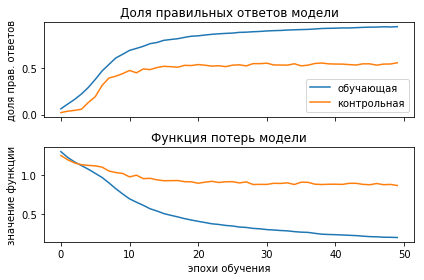

Train set statistics:
0 - 309 segments
1 - 247 segments
2 - 352 segments
3 - 351 segments
4 - 360 segments
5 - 328 segments
6 - 353 segments
8 - 360 segments
9 - 320 segments
10 - 361 segments
11 - 359 segments
12 - 356 segments
13 - 360 segments
14 - 360 segments
15 - 289 segments
16 - 360 segments
17 - 339 segments
18 - 357 segments
19 - 360 segments
20 - 355 segments
21 - 235 segments
22 - 358 segments
23 - 303 segments
24 - 211 segments
25 - 346 segments
26 - 315 segments
27 - 351 segments
28 - 354 segments
29 - 308 segments
30 - 235 segments
31 - 318 segments
32 - 352 segments
33 - 353 segments
34 - 249 segments
35 - 358 segments
36 - 360 segments
37 - 341 segments
38 - 360 segments
39 - 164 segments
40 - 352 segments
41 - 360 segments
42 - 353 segments
43 - 284 segments
44 - 340 segments
45 - 360 segments
46 - 360 segments
47 - 360 segments
48 - 360 segments
49 - 352 segments
Test set statistics:
0 - 107 segments
1 - 95 segments
2 - 120 segments
3 - 77 segments
4 - 120 segments
5

16188/16188 [==============================] - 7s - loss: 0.2071 - acc: 0.9364 - val_loss: 0.8657 - val_acc: 0.5552
Reloading best model to validate
Loading meta info
Model evaluation results:
Trained on fold1, fold3, fold4, validated on fold2
Fragment accuracy: 0.5674
Accuracy: 0.7372
F1-Score (weighted): 0.7181
                          precision    recall  f1-score   support

               101 - Dog     0.7000    0.8750    0.7778         8
           102 - Rooster     0.7273    1.0000    0.8421         8
               103 - Pig     0.7000    0.8750    0.7778         8
               104 - Cow     0.6667    1.0000    0.8000         8
              105 - Frog     1.0000    0.8750    0.9333         8
               106 - Cat     1.0000    0.6250    0.7692         8
               107 - Hen     0.7778    0.8750    0.8235         8
  108 - Insects (flying)     0.5714    0.5000    0.5333         8
             109 - Sheep     0.8750    0.8750    0.8750         8
              110 - Crow

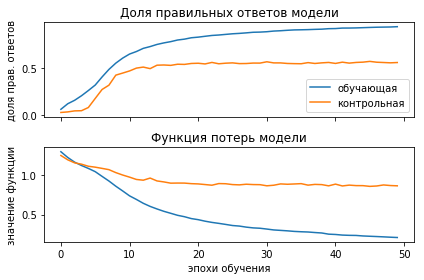

Train set statistics:
0 - 307 segments
1 - 257 segments
2 - 360 segments
3 - 308 segments
4 - 360 segments
5 - 317 segments
6 - 336 segments
8 - 356 segments
9 - 341 segments
10 - 361 segments
11 - 360 segments
12 - 364 segments
13 - 360 segments
14 - 360 segments
15 - 337 segments
16 - 360 segments
17 - 335 segments
18 - 357 segments
19 - 360 segments
20 - 353 segments
21 - 229 segments
22 - 352 segments
23 - 279 segments
24 - 258 segments
25 - 346 segments
26 - 331 segments
27 - 351 segments
28 - 360 segments
29 - 299 segments
30 - 239 segments
31 - 300 segments
32 - 353 segments
33 - 323 segments
34 - 269 segments
35 - 358 segments
36 - 360 segments
37 - 345 segments
38 - 360 segments
39 - 238 segments
40 - 359 segments
41 - 360 segments
42 - 356 segments
43 - 296 segments
44 - 340 segments
45 - 360 segments
46 - 360 segments
47 - 360 segments
48 - 357 segments
49 - 348 segments
Test set statistics:
0 - 109 segments
1 - 85 segments
2 - 112 segments
3 - 120 segments
4 - 120 segments


16295/16295 [==============================] - 7s - loss: 0.1929 - acc: 0.9407 - val_loss: 0.8706 - val_acc: 0.5478
Reloading best model to validate
Loading meta info
Model evaluation results:
Trained on fold1, fold2, fold4, validated on fold3
Fragment accuracy: 0.5608
Accuracy: 0.7245
F1-Score (weighted): 0.7116
                          precision    recall  f1-score   support

               101 - Dog     0.5455    0.7500    0.6316         8
           102 - Rooster     1.0000    0.8750    0.9333         8
               103 - Pig     0.8750    0.8750    0.8750         8
               104 - Cow     1.0000    1.0000    1.0000         8
              105 - Frog     1.0000    0.7500    0.8571         8
               106 - Cat     0.6667    0.2500    0.3636         8
               107 - Hen     0.6000    0.3750    0.4615         8
  108 - Insects (flying)     0.8000    1.0000    0.8889         8
             109 - Sheep     0.8750    0.8750    0.8750         8
              110 - Crow

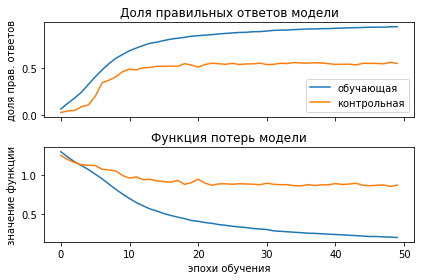

Train set statistics:
0 - 306 segments
1 - 249 segments
2 - 352 segments
3 - 308 segments
4 - 360 segments
5 - 322 segments
6 - 329 segments
8 - 356 segments
9 - 336 segments
10 - 360 segments
11 - 359 segments
12 - 360 segments
13 - 360 segments
14 - 360 segments
15 - 296 segments
16 - 360 segments
17 - 335 segments
18 - 360 segments
19 - 360 segments
20 - 358 segments
21 - 233 segments
22 - 350 segments
23 - 283 segments
24 - 232 segments
25 - 346 segments
26 - 318 segments
27 - 351 segments
28 - 354 segments
29 - 300 segments
30 - 212 segments
31 - 298 segments
32 - 357 segments
33 - 330 segments
34 - 273 segments
35 - 358 segments
36 - 360 segments
37 - 344 segments
38 - 360 segments
39 - 198 segments
40 - 360 segments
41 - 360 segments
42 - 351 segments
43 - 283 segments
44 - 350 segments
45 - 360 segments
46 - 360 segments
47 - 360 segments
48 - 357 segments
49 - 348 segments
Test set statistics:
0 - 110 segments
1 - 93 segments
2 - 120 segments
3 - 120 segments
4 - 120 segments


16132/16132 [==============================] - 7s - loss: 0.3117 - acc: 0.8903 - val_loss: 0.8144 - val_acc: 0.5942
Reloading best model to validate
Loading meta info
Model evaluation results:
Trained on fold1, fold2, fold3, validated on fold4
Fragment accuracy: 0.5942
Accuracy: 0.7372
F1-Score (weighted): 0.7245
                          precision    recall  f1-score   support

               101 - Dog     0.8889    1.0000    0.9412         8
           102 - Rooster     0.8000    1.0000    0.8889         8
               103 - Pig     0.7778    0.8750    0.8235         8
               104 - Cow     0.7273    1.0000    0.8421         8
              105 - Frog     1.0000    0.8750    0.9333         8
               106 - Cat     0.5714    0.5000    0.5333         8
               107 - Hen     0.6667    0.7500    0.7059         8
  108 - Insects (flying)     0.3333    0.2500    0.2857         8
             109 - Sheep     0.8750    0.8750    0.8750         8
              110 - Crow

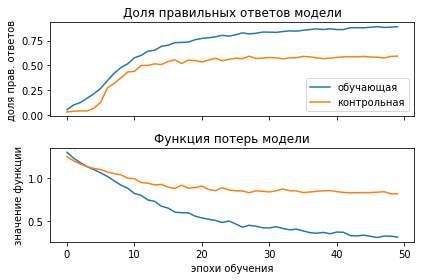

Final statistics:
Fragment accuracy. Mean: 0.5691, std: 0.0153
Accuracy. Mean: 0.7341, std: 0.0055
F1-Score. Mean: 0.7187, std: 0.0047


In [114]:
def plot_history(history):
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Доля правильных ответов модели')
    plt.ylabel('доля прав. ответов')
    plt.legend(['обучающая', 'контрольная'], loc='best')
    plt.setp(ax1.get_xticklabels(), visible=False)

    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Функция потерь модели')
    plt.ylabel('значение функции')
    plt.xlabel('эпохи обучения')

    plt.tight_layout()
    plt.show()

def evaluate(model, dataset, use_heldout=False, epochs=30, min_lr=0.0002):
    accuracies = []
    frag_accuracies = []
    f1s = []
    for train_folds, test_folds in dataset.kfold_names(use_heldout=use_heldout):
        results = model.train_on(dataset, train_folds, test_folds,
                                 epochs=epochs, validate=True, min_lr=min_lr)
        print('Model evaluation results:')
        print('Trained on %s, validated on %s' % (', '.join(train_folds), ', '.join(test_folds)))
        print('Fragment accuracy: %.4f' % results.frag_acc)
        frag_accuracies.append(results.frag_acc)
        accuracy = results.get_accuracy()
        accuracies.append(accuracy)
        print('Accuracy: %.4f' % accuracy)
        f1_score = results.get_f1_score(average='weighted')
        f1s.append(f1_score)
        print('F1-Score (weighted): %.4f' % f1_score)
        results.print_classification_report()

        if model.history is not None:
            plot_history(model.history)
        else:
            print('Learning history is not found')

    print('Final statistics:')
    print('Fragment accuracy. Mean: %.4f, std: %.4f' % (np.mean(frag_accuracies),
                                                        np.std(frag_accuracies)))
    print('Accuracy. Mean: %.4f, std: %.4f' % (np.mean(accuracies), np.std(accuracies)))
    print('F1-Score. Mean: %.4f, std: %.4f' % (np.mean(f1s), np.std(f1s)))

model = AlexLikeModel(lr=0.0003, suff='_lr0-0003')
evaluate(model, dataset, use_heldout=True, epochs=50)

Подбор архитектуры сети (слоёв и их параметров), а также параметров предобработки был тактично опущен, т.к. он осуществлялся мной в том числе в рамках моей выпускной работы. Чтобы повторить все вычисления заново, потребовалось бы несколько суток непрерывной работы компьютера со 100% загрузкой видеокарты, что я сейчас не могу сделать. Прошу не снижать за это баллы :(

Могу отметить, что при увеличении Dropout модель недообучается, а при увеличении learning rate модель сильно колбасит и её итоговое качество непредсказуемо, но обычно ниже той, что достигается при более низких значениях.

По кривым обучения можно видеть, что модель не переобучается, а выходит на плато. Если добавить больше данных и усложить модель, можно достигнуть более высоких результатов.

### 9. Создание новых признаков и описание этого процесса

Помимо логарифмированных мел-спектрограмм можно использовать дельта-коэффициенты, что и было сделано в экспериментах выше. О том, что это такое, можно прочитать <a href="http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/">здесь</a> и <a href="https://librosa.github.io/librosa/generated/librosa.feature.delta.html">здесь</a>. Если в кратце, то они представляют собой аналог численной производной.

Посчитанные коэффициенты добавляются к исходным признакам в виде "канала" по аналогии с каналами в изображении. После добавления мы получаем уже четырёхмерную матрицу данных. Также в качестве каналов можно добавить дельта-коэффициенты от дельта-коэффициентов, а также MFCC.
Эксперименты за кулисами показали увеличение качества лишь от добавления дельта-коэффициентов на наборе ESC-50.

### 11. Прогноз для тестовой или отложенной выборки

Train set statistics:
0 - 416 segments
1 - 342 segments
2 - 472 segments
3 - 428 segments
4 - 480 segments
5 - 426 segments
6 - 449 segments
8 - 476 segments
9 - 440 segments
10 - 481 segments
11 - 479 segments
12 - 476 segments
13 - 480 segments
14 - 480 segments
15 - 409 segments
16 - 480 segments
17 - 452 segments
18 - 477 segments
19 - 480 segments
20 - 473 segments
21 - 316 segments
22 - 470 segments
23 - 392 segments
24 - 311 segments
25 - 466 segments
26 - 428 segments
27 - 471 segments
28 - 474 segments
29 - 401 segments
30 - 306 segments
31 - 402 segments
32 - 472 segments
33 - 443 segments
34 - 348 segments
35 - 478 segments
36 - 480 segments
37 - 456 segments
38 - 480 segments
39 - 270 segments
40 - 472 segments
41 - 480 segments
42 - 470 segments
43 - 391 segments
44 - 460 segments
45 - 480 segments
46 - 480 segments
47 - 480 segments
48 - 477 segments
49 - 468 segments
Test set statistics:
0 - 106 segments
1 - 94 segments
2 - 67 segments
3 - 117 segments
4 - 120 segments
5

21618/21618 [==============================] - 9s - loss: 0.2071 - acc: 0.9346 - val_loss: 0.8898 - val_acc: 0.5364
Reloading best model to validate
Loading meta info
Model evaluation results:
Trained on fold1, fold2, fold3, fold4, validated on fold5
Fragment accuracy: 0.5588
Accuracy: 0.7270
F1-Score (weighted): 0.7067
                          precision    recall  f1-score   support

               101 - Dog     0.8571    0.7500    0.8000         8
           102 - Rooster     0.6667    1.0000    0.8000         8
               103 - Pig     0.4000    0.5000    0.4444         8
               104 - Cow     0.7000    0.8750    0.7778         8
              105 - Frog     1.0000    0.7500    0.8571         8
               106 - Cat     0.8889    1.0000    0.9412         8
               107 - Hen     1.0000    0.8750    0.9333         8
  108 - Insects (flying)     0.8333    0.6250    0.7143         8
             109 - Sheep     1.0000    1.0000    1.0000         8
              110

c:\users\shiz0\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 49, does not match size of target_names, 50
  .format(len(labels), len(target_names))


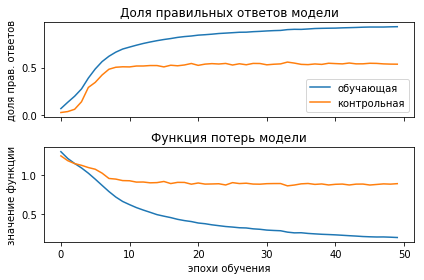

In [117]:
def evaluate_validation(model, dataset, epochs=30, min_lr=0.0002):
    accuracies = []
    frag_accuracies = []
    f1s = []
    train_folds = ['fold1', 'fold2', 'fold3', 'fold4']
    test_folds = ['fold5']
    results = model.train_on(dataset, train_folds, test_folds,
                             epochs=epochs, validate=True, min_lr=min_lr)
    print('Model evaluation results:')
    print('Trained on %s, validated on %s' % (', '.join(train_folds), ', '.join(test_folds)))
    print('Fragment accuracy: %.4f' % results.frag_acc)
    frag_accuracies.append(results.frag_acc)
    accuracy = results.get_accuracy()
    accuracies.append(accuracy)
    print('Accuracy: %.4f' % accuracy)
    f1_score = results.get_f1_score(average='weighted')
    f1s.append(f1_score)
    print('F1-Score (weighted): %.4f' % f1_score)
    results.print_classification_report()

    if model.history is not None:
        plot_history(model.history)
    else:
        print('Learning history is not found')

model = AlexLikeModel(lr=0.0003, suff='_lr0-0003')
evaluate_validation(model, dataset, epochs=50)

Полученные результаты согласуются с данными кросс-валидации (отличие около 1%).

При помощи Tensorflow невозможно корректно зафиксировать зерно генератора псведослучайных чисел, т.к. библиотека cuDNN, которая задействуется внутри, в некоторых местах использует свой ГПСЧ, на который пока нельзя повлиять. Поэтому ваши результаты могут отличаться от моих, но незначительно.

### 12. Выводы

Данная модель хорошо показала себя при решении задачи классификации звуковых сигналов. Приведу сравнение с результатами автора набора данных (средняя доля правильных ответов на кросс-валидации):
* Мой результат - 73.4%
* k-NN - 32.2%
* Random Forest - 45.1%
* SVM - 39.5%

Я не стал подробно расписывать каждый параметр модели и то, почему именно такой был выбран, т.к. для этого потребовалось бы притащить теории на десятки страниц, потому что в курсе не разбирались нейросетевые модели. Если есть вопросы, могу поделиться своим небольшим опытом в чате ODS, а также выслушать вашу критику и пожелания: @fremis

Сейчас данная тема активно исследуется. На arXiv вы можете увидеть новые статьи по данной тематике чуть ли не каждый день. Даже проводится ежегодный конкурс DCASE, который проводится при спонсировании Google.

В этом году появился огромный набор данных от Google под названием Audioset, в котором содержится огромное количество звуков из видео на Youtube, разбитых на огромное количество категорий. Для того, чтобы переварить этот набор, потребуются уже более глубокие сети и соответствующие мощности. Также имеется огромное множество неразмеченных звуковых файлов, которые было бы неплохо задействовать при обучении модели (например, есть набор ESC-US от автора ESC-50, в котором содержится довольно много неразмеченных звуковых файлов). Для этого можно попытаться применить подходы, которые используются при работе с изображениями.